In [1]:
#!/usr/bin/env python3

def gaussian(x, mu, sigma, amp = 1):
    import numpy as np
    
    #since not using Norm. Dist. as PDF later, amplitude of 1 not necessarily correct
    coeff = amp/np.sqrt(2 * np.pi * (sigma**2)) 
    num = (x-mu)**2
    den = 2 * (sigma**2)

    return coeff * np.exp(-(num/den))

def open_calibration_data(user_file):
    
    """
    open calibration data directory and access measurements within
    """
    
    import os
    import logging
    logging.basicConfig(level = logging.DEBUG, format = '%(asctime)s - %(levelname)s - %(message)s')
    
    #format user_file for file_path
    file_name = '/' + user_file

    #access testPulseData directory
    test_pulse_dir = os.path.abspath('testPulseData')

    #create full path to file
    file_path = test_pulse_dir + file_name

    logging.debug('file_path = %s' %file_path)
    
    file = open(file_path)
    raw_data = file.readlines()
    file.close()
    
    return raw_data

def calibrate_MCA(user_file):
    
    """
    calculate the mean and standard deviation of a normal distribution (Norm. Dist.) centered 
    on the peaks of user_file
    
    display the Norm. Dist. and signal histogram together on a plot
    """
    
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import norm
    import logging
    logging.basicConfig(level = logging.DEBUG, format = '%(asctime)s - %(levelname)s - %(message)s')

    raw_data = open_calibration_data(user_file)
    
    #list of signal + noise counts
    count_data = raw_data[12:len(raw_data) - 1]

    #array of signal + noise counts recorded in data file
    count_array = np.array(count_data, dtype = int)
    
    #educated guess based on height of outermost peaks surrounding maxima
    threshold = 10
    
    signal = []
    
    #strip noise based on threshold
    for dataPoint in count_array:
        if dataPoint > threshold:
            signal.append(dataPoint)
        else:
            signal.append(0)
            
    signal = np.array(signal, dtype = int)
    
    #largest count recorded
    max_amplitude = np.amax(signal)
    
    #index of maxima 
    mean_adjustment = np.argmax(signal)
    
    #calculate mean and standard deviation of the counts
    mean, std_dev = norm.fit(signal)
    logging.debug('mean:  %f\nstd_dev:  %f' %(mean, std_dev))
    
    #adjusted mean that centers distribution on a maxima
    distribution_center = mean + mean_adjustment
    logging.debug('distribution center:  %f' %distribution_center)
    
    #physical detector has 1024 channels 
    bins_array = np.linspace(1, 1024, 1024)
    
    #calculate the value of the normal distribution across the domain [1, 1024]
    gauss_y = gaussian(bins_array, distribution_center, std_dev, max_amplitude*1e2)
    
    #plot the raw data as a histogram
    plt.bar(bins_array, signal);
    #plot the normal distribution on top of the histogram
    plt.plot(bins_array, gauss_y, 'k-');
    plt.show()
    
    
    return (distribution_center, mean, std_dev)


calibrate_MCA('test_pulse_0.5V.mca')

2019-02-24 13:48:30,827 - DEBUG - file_path = /Users/nikourriola/Desktop/sp19/phys403/alpha/calibration/testPulseData/test_pulse_0.5V.mca
2019-02-24 13:48:30,829 - DEBUG - mean:  3.157227
std_dev:  32.352304
2019-02-24 13:48:30,830 - DEBUG - distribution center:  388.157227


(388.1572265625, 3.1572265625, 32.35230391904948)

In [2]:
#!usr/bin/env python3

def emev(vPulse):

    """
    calculate the equivalent test pulse energy (MeV)

    calculation follows from equations found on page 5 in 'Range of Alpha Particles in Gas'

    @input:  vpulse - voltage of the test pulse as read from oscilloscope (V)

    @output: equivalentE - equivalent energy of the test pulse in MeV
    """

    #C1 = 0.4095 pF according to the case of the preamplifier
    qtest = (0.4095e-12) * vPulse

    #equivalence relation
    equivalentE = 2.26e13 * qtest
    
    print(equivalentE)
    
    return equivalentE


2019-02-24 13:48:38,039 - DEBUG - ['copypulse.mca', 'test_pulse_0.5V.mca', 'test_pulse_0.6V.mca', 'test_pulse_0.7V.mca', 'test_pulse_0.8V.mca', 'test_pulse_0.9V.mca', 'test_pulse_1.0V.mca', 'test_pulse_1.1V.mca', 'test_pulse_1.2V.mca', 'test_pulse_1.3V.mca', 'test_pulse_1.4V.mca', 'test_pulse_1.5V.mca']
2019-02-24 13:48:38,040 - DEBUG - file_path = /Users/nikourriola/Desktop/sp19/phys403/alpha/calibration/testPulseData/test_pulse_0.5V.mca
2019-02-24 13:48:38,044 - DEBUG - mean:  3.157227
std_dev:  32.352304
2019-02-24 13:48:38,049 - DEBUG - distribution center:  388.157227


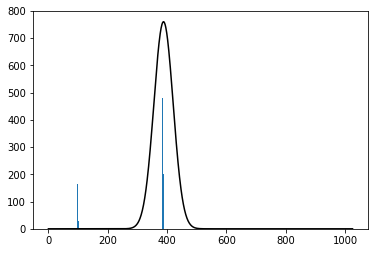

2019-02-24 13:48:39,781 - DEBUG - file_path = /Users/nikourriola/Desktop/sp19/phys403/alpha/calibration/testPulseData/test_pulse_0.5V.mca
2019-02-24 13:48:39,783 - DEBUG - mean:  3.157227
std_dev:  32.352304
2019-02-24 13:48:39,784 - DEBUG - distribution center:  388.157227


In [ ]:
#!/usr/bin/env python 3

import os
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level = logging.DEBUG, format = '%(asctime)s - %(levelname)s - %(message)s')

"""
apply calibrate_MCA to all data sets within testPulseData directory

create arrays to be used for translating channel number to energy
"""

file_list = None
for root, dirs, files in os.walk('testPulseData', topdown = False):
       file_list = files

#sort the calibration files by name
file_list.sort()
logging.debug(file_list)

x_data = []
x_error = []
for fileName in file_list[1:]:
    #calculate the Norm. Dist. mean for every calibration data set
    dist_center_val = calibrate_MCA(fileName)[0]
    #add the normal distribution mean to a list x_data
    x_data.append(dist_center_val)
    
    #calculate the Norm. Dist. standard deviation for every calibration data set
    std_dev_val = calibrate_MCA(fileName)[2]
    #add the normal distribution std to a list x_error
    x_error.append(std_dev_val)

#convert x_data list into an array 
x_data = np.array(x_data)
logging.debug('x_data:  %s' %x_data)

#convert x_error list into an array
x_error = np.array(x_error)
logging.debug('x_error:  %s' %x_error) 



In [4]:
"""
create an array containing the equivalent energies for ALL the test pulse voltages measured
"""

pulse_voltage = np.linspace(0.5, 1.5, 11)
logging.debug(pulse_voltage)

y_data = emev(pulse_voltage)
logging.debug('y_data:  %s' %y_data)

assert(len(x_data) == len(y_data))

2019-02-22 23:03:08,798 - DEBUG - [0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5]
2019-02-22 23:03:08,807 - DEBUG - y_data:  [ 4.62735  5.55282  6.47829  7.40376  8.32923  9.2547  10.18017 11.10564
 12.03111 12.95658 13.88205]


[ 4.62735  5.55282  6.47829  7.40376  8.32923  9.2547  10.18017 11.10564
 12.03111 12.95658 13.88205]


'\nobserve that the data point (1.5V --> Ch 96.789062, 13.88) "pulls up" the slope of the calibration curve\n\nunder the assumption that our DAQ is acceptable up to this equivalent energy, \nthen, eliminate this data point and recalculate the calibration line (linear regression)\n'

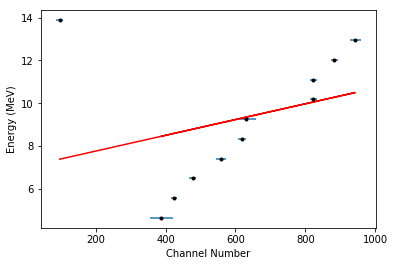

In [5]:
"""
calculate a best fit line based on (ALL) the calibration data
"""
def line(x, m, b):
    return (m*x) + b

import scipy.stats as sps

#includes data point at 1.5V
fit_results = sps.linregress(x_data, y_data)

yFit = line(x_data, fit_results[0], fit_results[1])

plt.plot(x_data, yFit, 'r-');

plt.plot(x_data, y_data, 'k.');
plt.xlabel('Channel Number')
plt.ylabel('Energy (MeV)')
plt.errorbar(x_data, y_data, xerr = x_error, fmt = 'none')

'''
observe that the data point (1.5V --> Ch 96.789062, 13.88) "pulls up" the slope of the calibration curve

under the assumption that our DAQ is acceptable up to this equivalent energy, 
then, eliminate this data point and recalculate the calibration line (linear regression)
'''

2019-02-22 23:03:09,084 - DEBUG - x:  [388.15722656 423.83105469 477.89453125 558.32421875 618.99902344
 629.73046875 822.92675781 822.92675781 882.89355469 942.45410156]
2019-02-22 23:03:09,085 - DEBUG - y:  [ 4.62735  5.55282  6.47829  7.40376  8.32923  9.2547  10.18017 11.10564
 12.03111 12.95658]
2019-02-22 23:03:09,087 - DEBUG - slope:  0.013863
intercept:  -0.313343
2019-02-22 23:03:09,092 - DEBUG - r value:  0.987051


<Container object of 3 artists>

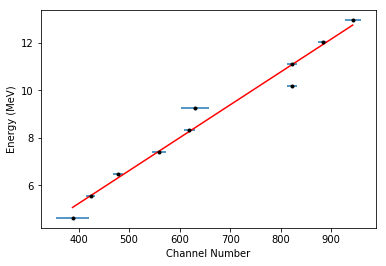

In [6]:
"""
assuming that the measurement at 1.5V is an outlier that can be ignored,
calculate a best fit line based on the remaining calibration data
"""

mod_x_data = x_data[:len(x_data)-1]
mod_y_data = y_data[:len(y_data)-1]
logging.debug('x:  %s' %mod_x_data)
logging.debug('y:  %s' %mod_y_data)


mod_x_error = x_error[:len(x_error)-1]

def line(x, m, b):
    return (m*x) + b

import scipy.stats as sps

#does not contain a data point at 1.5V
mod_fit_results = sps.linregress(mod_x_data, mod_y_data)

mod_yFit = line(mod_x_data, mod_fit_results[0], mod_fit_results[1])
logging.debug('slope:  %f\nintercept:  %f' %(mod_fit_results[0], mod_fit_results[1]))
logging.debug('r value:  %f' %mod_fit_results[2])

plt.plot(mod_x_data, mod_yFit, 'r-');

plt.plot(mod_x_data, mod_y_data, 'k.');
plt.xlabel('Channel Number')
plt.ylabel('Energy (MeV)')
plt.errorbar(mod_x_data, mod_y_data, xerr = mod_x_error, fmt = 'none')

The resulting equation describes the best fit line that will be used for translating channel number to energy


y =  0.013863 * x +  (-0.313343)

What happens if instead of plotting the best fit line for the modified domain, the best fit is plotted for a generalized domain? I think the best fit should retain the same form, but also extend outside the modified domain.

2019-02-22 23:06:04,254 - DEBUG - slope:  0.013863
intercept:  -0.313343
2019-02-22 23:06:04,255 - DEBUG - r value:  0.987051


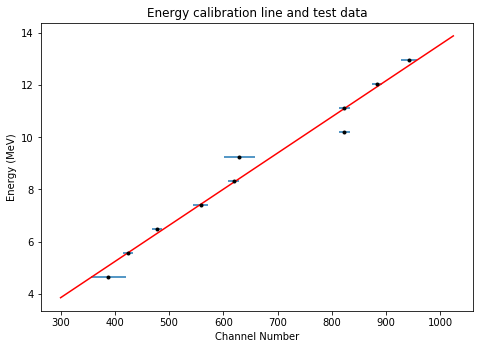

In [11]:
"""
general_domain is an extension of the domain beyond the lowest data point and up to the highest recorded data point
that is:  [0, 1024] using 10e3 steps
"""

mod_x_data = x_data[:len(x_data)-1]
mod_y_data = y_data[:len(y_data)-1]

mod_x_error = x_error[:len(x_error)-1]

def line(x, m, b):
    return (m*x) + b

import scipy.stats as sps

#does not contain a data point at 1.5V
mod_fit_results = sps.linregress(mod_x_data, mod_y_data)

general_domain = np.linspace(300, 1024, 10000)
mod_yFit = line(general_domain, mod_fit_results[0], mod_fit_results[1])
logging.debug('slope:  %f\nintercept:  %f' %(mod_fit_results[0], mod_fit_results[1]))
logging.debug('r value:  %f' %mod_fit_results[2])

fig = plt.figure()
ax = fig.add_axes([1,1,1,1])

plt.plot(general_domain, mod_yFit, 'r-');

plt.plot(mod_x_data, mod_y_data, 'k.');
plt.xlabel('Channel Number')
plt.ylabel('Energy (MeV)')
plt.title('Energy calibration line and test data')

mod_y_error = [0.6287,0.6287,0.6287,0.6287,0.6287,0.6287,0.6287,0.6287,0.6287,0.6287]


plt.errorbar(mod_x_data, mod_y_data, xerr = mod_x_error, yerr = mod_y_error fmt = 'none')

fig.savefig('calibrationPlot.png', bbox_inches = 'tight')

It would seem our intuition was correct